# Centrifugation Model

This notebook details the development, discovery, and implementation of a centrifugation model. The model explores how the "Ratios of Ratios" within a distribution are affected over time, as observed in centrifugation processes.

# Background Theory

The theoretical foundation is straightforward, based on the sedimentation theory outlined by Mohr, H., & Völkl, A. (2017) in "Ultracentrifugation."

The sedimentation speed is defined as:

$$
\text{𝜈} = \frac{2r_s^2 (\rho_s - \rho_l)}{9\eta} F
$$

Where:

$$
F = \omega^2 r
$$

## Implementation

### Initial State

- **Uniform Distribution**: Each concentration of particles is assumed to be uniformly distributed in 1D space.
- **Parameter Setup**: Key parameters such as centrifuge speed, duration, arm length, particle and fluid density, and fluid viscosity are established.

### Sedimentation Rates

- **Determining Sedimentation Velocity**: Based on the parameters set, the sedimentation velocity is calculated for each particle size.

### Pellets or Supernatant

- **Classification**: Based on sedimentation velocities and the duration of centrifugation, a proportion of particles will reach the bottom of the container, forming pellets. Particles that do not reach the bottom will remain in the supernatant.

### Ratio of Ratios

- **New Concentration Distribution**: A new concentration distribution for each particle size is determined by reducing the initial concentration of particles by the ratio of particles that form pellets.
- **Centrifugation Cycles**: This reduction process, where the ratio is adjusted by another ratio over centrifugation cycles, is a key focus of the model.

---

Mohr, H., & Völkl, A. (2017). Ultracentrifugation. In eLS, John Wiley & Sons, Ltd (Ed.) (pp. 1-9).

---

In [8]:
# Loading in the Libraries
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from scipy.stats import gamma

# Allows for the hot reloading of modules
%load_ext autoreload
%autoreload 2


# Loading in the Simulation Objects
from src.Centrifugation import *
from src.DataLoader import load_data_from_txt, normalize_data, load_data_from_excel

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# Standard Centrifugation parms
time = 10 # (min)
rpm = 4000
arm_length = 10 * 1e-2 # length of centrifuge 10cm  (m)
length = 1 * 1e-2 # tube length 1cm (m)

# Liquid parms
liquid_density = 997 # water (kg/m^2)
liquid_viscosity = 1 # water (mPa.s)

# Particle parms
particle_density = 2330 # silicon (kg.m^2)

First, lets get just the composition change of a single particle size by reducing the amount of supernantant particle as the particles become pallet. 


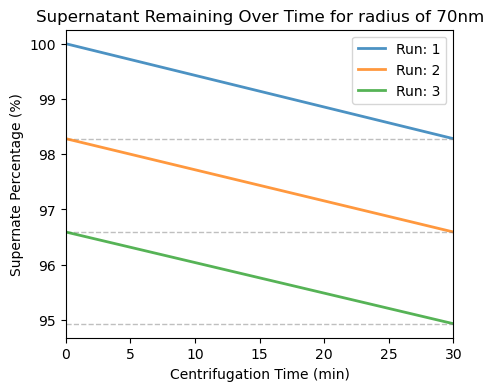

In [10]:
# How does mutiple runs look for a single size particle?
size = 70 * 1e-9
rpm = 1000
runs = 3

prob = 1

fig, ax = plt.subplots(figsize=(5,4))
for run in range(runs):
    time = np.linspace(0,30,100)
    prob_remaining = cal_remaining_percent(size, prob, time,
                                            particle_density, liquid_density, liquid_viscosity,
                                            rpm, arm_length, length)
    prob = prob_remaining[-1]
    ax.plot(time, prob_remaining * 1e2, label=f"Run: {run +1}", alpha = 0.8, linewidth=2) 

    # Add a gray dotted line at y=prob
    ax.axhline(y=prob * 1e2, color='gray', linestyle='--', linewidth=1, alpha=0.5)

# ax.set_ylim([0,100])
ax.set_xlim([0,time[-1]])

ax.set_xlabel("Centrifugation Time (min)")
ax.set_ylabel("Supernate Percentage (%)")
ax.set_title(f'Supernatant Remaining Over Time for radius of {size * 1e9:.0f}nm')
ax.legend()


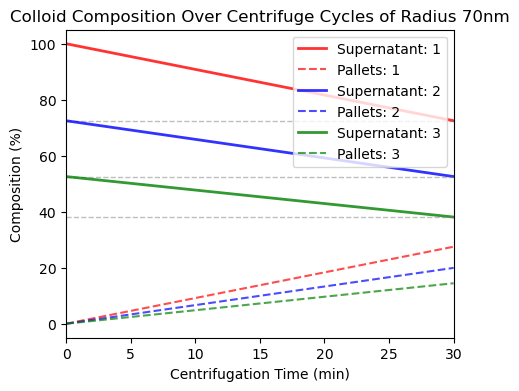

In [12]:
# Pallets and supernatants
size = 70 * 1e-9
rpm = 4000
runs = 3

prob = 1

# Define a color cycle for different runs
colors = ['red', 'blue', 'green']

fig, ax = plt.subplots(figsize=(5,4))
for run in range(runs):
    time = np.linspace(0,30,100)
    supernate, pallets = cal_supernate_and_pallets(size, prob, time,
                                            particle_density, liquid_density, liquid_viscosity,
                                            rpm, arm_length, length)
    prob = supernate[-1]
    ax.plot(time, supernate * 1e2, label=f"Supernatant: {run +1}", alpha = 0.8, linewidth=2, color=colors[run]) 
    ax.plot(time, pallets * 1e2, label=f"Pallets: {run + 1}", alpha=0.7, linestyle='--', color=colors[run])

    # Add a gray dotted line at y=prob
    ax.axhline(y=prob * 1e2, color='gray', linestyle='--', linewidth=1, alpha=0.5)

# ax.set_ylim([0,100])
ax.set_xlim([0,time[-1]])

ax.set_xlabel("Centrifugation Time (min)")
ax.set_ylabel("Composition (%)")
ax.set_title(f'Colloid Composition Over Centrifuge Cycles of Radius {size * 1e9:.0f}nm')
ax.legend()


The plot above shows the change in composition of particles of a single size (70 nm) over the course of several centrifugation cycles. As we can see, the amount of particles that become part of the pellet increases with each centrifugation run, while the amount remaining in the supernatant decreases.

It's important to note that the percentages displayed are relative to the total initial composition of that specific particle size. This helps to illustrate how the proportion of particles changes as they are separated into supernatant and pellet fractions through repeated centrifugation.

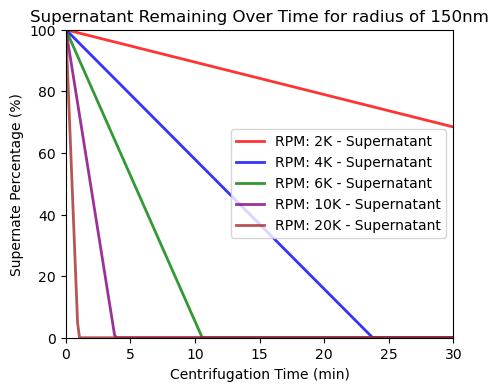

In [44]:
# How does speed effect the change over time
count = 1000
size = 150 * 1e-9
rpm = np.array([2000, 4000, 6000, 10000, 20000])
j = 0

fig, ax = plt.subplots(figsize=(5,4))

colors = ['red', 'blue', 'green', 'purple', 'brown']

for speed in rpm:
    prob = 1
    time = np.linspace(0,30,200)
    prob, pallets = cal_supernate_and_pallets(size, prob, time,
                                          particle_density, liquid_density, liquid_viscosity,
                                         speed, arm_length, length)
    
    
#     ax.plot(time, remaining_percent * 1e2, label=f"RPM: {speed * 1e-3:.0f}K", alpha = 0.8, linewidth=2)
    ax.plot(time, prob * 1e2, label=f"RPM: {speed * 1e-3:.0f}K - Supernatant", alpha = 0.8, linewidth=2, color=colors[j]) 
#     ax.plot(time, pallets * 1e2, label=f"RPM: {speed * 1e-3:.0f}K - Pallets", alpha=0.7, linestyle='--', color=colors[j])
    j += 1
    

ax.set_ylim([0,100])
ax.set_xlim([0,time[-1]])

ax.set_xlabel("Centrifugation Time (min)")
ax.set_ylabel("Supernate Percentage (%)")
ax.set_title(f'Supernatant Remaining Over Time for radius of {size * 1e9:.0f}nm')
ax.legend()


The plot above illustrates how the rate of sedimentation (indicated by the gradient) for particles of a specific size (150 nm) depends on the centrifugation speed (RPM). As the RPM increases, the rate at which particles sediment and leave the supernatant accelerates, leading to a steeper decline in the supernatant percentage over time. This demonstrates the strong influence of centrifugation speed on the efficiency of particle separation.

---

### Testing the Behavior of the Model - Uniform Size Distribution

Before expanding the investigation to explore how the model performs on a complete size distribution, let's first assume that each particle size is equally likely and contributes equally to the overall composition.

This check serves two purposes:
1. **Testing Our Understanding**: It allows us to verify our understanding of how the "ratio of ratios" evolves over time across a uniform size distribution.
2. **Validating Sedimentation Rates**: It ensures that different particle sizes exhibit different sedimentation rates and that the pellets are formed according to the sedimentation rates of each particle size.


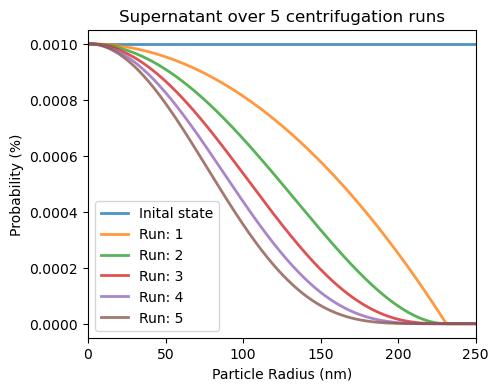

In [210]:
# How does the distribution of the particles over multiple runs change.
runs = 5
count = 1000
size = np.linspace(1,251,count) * 1e-9
rpm = 4000

# normalised to have all size equally likly
prob = np.ones(count) / count
times = 10


fig, ax = plt.subplots(figsize=(5,4))

ax.plot(size*1e9, prob, label=f"Inital state", alpha = 0.8, linewidth=2)

 
for j in range(runs):

    for i in range(count):
        prob[i], pallets = cal_supernate_and_pallets(size[i], prob[i], times,
                                              particle_density, liquid_density, liquid_viscosity,
                                             rpm, arm_length, length)
        
    ax.plot(size*1e9, prob, label=f"Run: {j+ 1}", alpha = 0.8, linewidth=2)

    
ax.set_xlim([0,250])
# ax.set_ylim([0,1.1])

ax.set_xlabel("Particle Radius (nm)")
ax.set_ylabel("Composition (%)")
ax.set_title(f"Supernatant over {runs} centrifugation runs")
ax.legend()


---

### Testing the behavour of the model - Non-uniformed Distribution

Before comparing the model to experimental results, it's essential to observe the behavior of the model when using a gamma distribution.

The gamma distribution is supported in the literature as being more appropriate than a Gaussian distribution for modeling the size distribution produced by Pulsed Laser Ablation in Liquids (PLAL). The gamma distribution, when normalized, represents the contribution of each particle size to the overall size distribution.

It's well-established that the size distribution in colloids is not uniform. Instead, literature suggests that it follows a gamma distribution. While it would be ideal to evolve the simulation to use a measured distribution in the future, starting with the gamma distribution is a solid initial approach.

The Composition (%) in this context indicates how much of the overall colloid contains a specific size of particle.

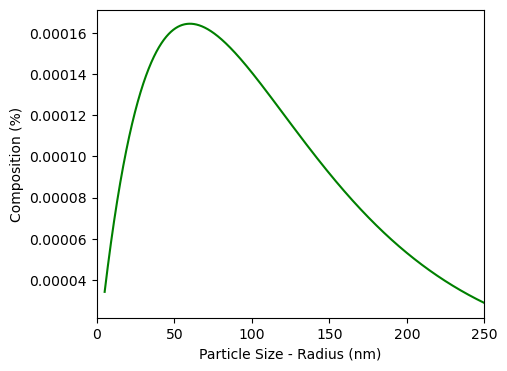

In [114]:
# Inital size distribution - gamma distribution
count = 10000
size = np.linspace(5,251,count) * 1e-9

shape_param = 2  # shape parameter (k)
scale_param = 60  # scale parameter (theta)

probability = gamma.pdf(size * 1e9, shape_param, scale=scale_param)

# Normalize the probability
probability /= np.sum(probability)

fig, ax = plt.subplots(figsize=(5,4))
ax.plot(size*1e9, probability, color='Green')

ax.set_xlim([0,250])
# ax.set_ylim([0,1.1])

ax.set_xlabel("Particle Size - Radius (nm)")
ax.set_ylabel("Composition (%)")

plt.show(fig)

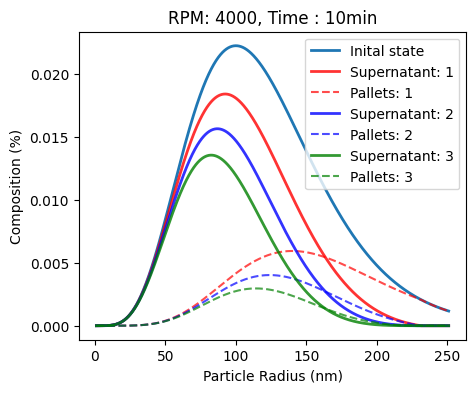

In [33]:
# How does the distribution supernate and pallets of the particles over multiple runs change.
runs = 3
# count = 1000
# size = np.linspace(1,251,count) * 1e-9

# Inital size distribution - uniformed distribution
count = 10000
size = np.linspace(1,251,count) * 1e-9

shape_param = 6.0  # shape parameter (k)
scale_param = 20.0  # scale parameter (theta)

probability = gamma.pdf(size * 1e9, shape_param, scale=scale_param)

# Normalize the probability
probability /= np.sum(probability)
rpm = 4000

prob = probability
times = 10


# Define a color cycle for different runs
colors = ['red', 'blue', 'green']

fig, ax = plt.subplots(figsize=(5,4))

ax.plot(size*1e9, prob * 1e2, label=f"Inital state", linewidth=2)

 
for j in range(runs):
    pallets = np.zeros(count)

    for i in range(count):
        prob[i], pallets[i] = cal_supernate_and_pallets(size[i], prob[i], times,
                                              particle_density, liquid_density, liquid_viscosity,
                                             rpm, arm_length, length)
        
        
    ax.plot(size*1e9, prob * 1e2, label=f"Supernatant: {j +1}", alpha = 0.8, linewidth=2, color=colors[j]) 
    ax.plot(size*1e9, pallets * 1e2, label=f"Pallets: {j + 1}", alpha=0.7, linestyle='--', color=colors[j])


ax.set_xlabel("Particle Radius (nm)")
ax.set_ylabel("Composition (%)")
ax.set_title(f"RPM: {rpm}, Time : {times}min")
ax.legend()


### Do we need to normalise the Supernatant after each run???

Re-normalizing the composition after each run is necessary. This ensures that the recorded data, including the spectrum and composition, reflects the relative proportions within the overall composition of the sample being measured.

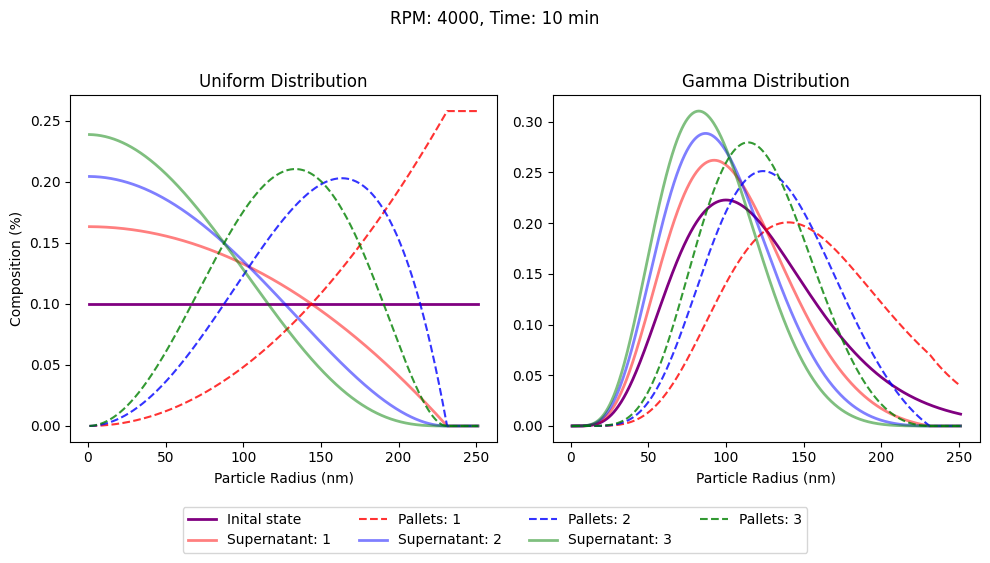

In [67]:
# Does the size distribution need to be normalised after each cycle?
runs = 3
count = 1000


# Inital size distribution - uniformed distribution
size = np.linspace(1,251,count) * 1e-9

shape_param = 6.0  # shape parameter (k)
scale_param = 20.0  # scale parameter (theta)

# 2 different distributions are used to see the shift in particle size distro from different inital states
probability_uniformed = np.ones(count)
probability_gamma = gamma.pdf(size * 1e9, shape_param, scale=scale_param)


# Normalize the probability --> just to ensure it works as expected
probability_uniformed /= np.sum(probability_uniformed)
probability_gamma /= np.sum(probability_gamma)
rpm = 4000

# This is the centrifugation time --> could be named duration
times = 10


# Define a color cycle for different runs
colors = ['red', 'blue', 'green']

fig, ax = plt.subplots(1,2, figsize=(10,5))

# Plotting the inital state of the particle distros
ax[0].plot(size*1e9, probability_uniformed * 1e2, label=f"Inital state", linewidth=2, color='purple')
ax[1].plot(size*1e9, probability_gamma * 1e2, label=f"Inital state", linewidth=2, color='purple')

# Loop over each run
for run in range(runs):

    # At each run, the pallets are set to zero --> due colloids are supernate in each sample
    pallets_uniformed = np.zeros(count)
    pallets_gamma = np.zeros(count)

    # loop over each particle size
    for particle in range(count):
        probability_uniformed[particle], pallets_uniformed[particle] = cal_supernate_and_pallets(size[particle], probability_uniformed[particle], times,
                                              particle_density, liquid_density, liquid_viscosity,
                                             rpm, arm_length, length)
        probability_gamma[particle], pallets_gamma[particle] = cal_supernate_and_pallets(size[particle], probability_gamma[particle], times,
                                              particle_density, liquid_density, liquid_viscosity,
                                             rpm, arm_length, length)
        
    # normalising prob and pallets
    
    probability_uniformed /= np.sum(probability_uniformed)
    pallets_uniformed /= np.sum(pallets_uniformed)

    probability_gamma /= np.sum(probability_gamma)
    pallets_gamma /= np.sum(pallets_gamma)

    ax[0].plot(size*1e9, probability_uniformed * 1e2, label=f"Supernatant: {run +1}", alpha = 0.5, linewidth=2, color=colors[run]) 
    ax[0].plot(size*1e9, pallets_uniformed * 1e2, label=f"Pallets: {run + 1}", alpha=0.8, linestyle='--', color=colors[run])

    ax[1].plot(size*1e9, probability_gamma * 1e2, label=f"Supernatant: {run +1}", alpha = 0.5, linewidth=2, color=colors[run]) 
    ax[1].plot(size*1e9, pallets_gamma * 1e2, label=f"Pallets: {run + 1}", alpha=0.8, linestyle='--', color=colors[run])


# Titles and labels
ax[0].set_title("Uniform Distribution")
ax[1].set_title("Gamma Distribution")
fig.suptitle(f"RPM: {rpm}, Time: {times} min")

# assigning the lables to plot axies
for a in ax:
    a.set_xlabel("Particle Radius (nm)")
ax[0].set_ylabel("Composition (%)")

# Shared legend placed below the plots
handles, labels = ax[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.0), ncol=4)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Normalizing the data after determining the reduction ratio of the supernatants as particles become pelleted seems to make the plots more insightful. This approach highlights the changes in composition more clearly as the process progresses.

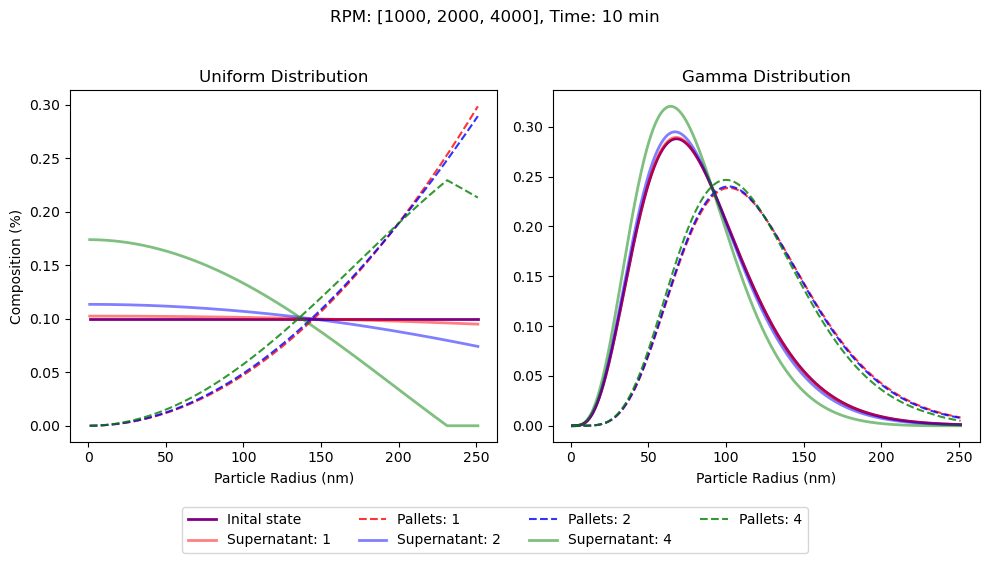

In [125]:
# Does the size distribution need to be normalised after each cycle?
RPMS = [1000, 2000, 4000]
count = 1000


# Inital size distribution - uniformed distribution
size = np.linspace(1,251,count) * 1e-9

shape_param = 5  # shape parameter (k)
scale_param = 17  # scale parameter (theta)

# 2 different distributions are used to see the shift in particle size distro from different inital states
probability_uniformed = np.ones(count)
probability_gamma = gamma.pdf(size * 1e9, shape_param, scale=scale_param)


# Normalize the probability --> just to ensure it works as expected
probability_uniformed /= np.sum(probability_uniformed)
probability_gamma /= np.sum(probability_gamma)
# rpm = 4000

# This is the centrifugation time --> could be named duration
times = 10


# Define a color cycle for different runs
colors = ['red', 'blue', 'green', 'pink', 'grey']
index = 0

fig, ax = plt.subplots(1,2, figsize=(10,5))

# Plotting the inital state of the particle distros
ax[0].plot(size*1e9, probability_uniformed * 1e2, label=f"Inital state", linewidth=2, color='purple')
ax[1].plot(size*1e9, probability_gamma * 1e2, label=f"Inital state", linewidth=2, color='purple')

# Loop over each run
for rpm in RPMS:

    # At each run, the pallets are set to zero --> due colloids are supernate in each sample
    pallets_uniformed = np.zeros(count)
    pallets_gamma = np.zeros(count)

    # loop over each particle size
    for particle in range(count):
        probability_uniformed[particle], pallets_uniformed[particle] = cal_supernate_and_pallets(size[particle], probability_uniformed[particle], times,
                                              particle_density, liquid_density, liquid_viscosity,
                                             rpm, arm_length, length)
        probability_gamma[particle], pallets_gamma[particle] = cal_supernate_and_pallets(size[particle], probability_gamma[particle], times,
                                              particle_density, liquid_density, liquid_viscosity,
                                             rpm, arm_length, length)
        
    # normalising prob and pallets
    
    probability_uniformed /= np.sum(probability_uniformed)
    pallets_uniformed /= np.sum(pallets_uniformed)

    probability_gamma /= np.sum(probability_gamma)
    pallets_gamma /= np.sum(pallets_gamma)

    ax[0].plot(size*1e9, probability_uniformed * 1e2, label=f"Supernatant: {rpm/1000:.0f}", alpha = 0.5, linewidth=2, color=colors[index]) 
    ax[0].plot(size*1e9, pallets_uniformed * 1e2, label=f"Pallets: {rpm/1000:.0f}", alpha=0.8, linestyle='--', color=colors[index])

    ax[1].plot(size*1e9, probability_gamma * 1e2, label=f"Supernatant: {rpm/1000:.0f}", alpha = 0.5, linewidth=2, color=colors[index]) 
    ax[1].plot(size*1e9, pallets_gamma * 1e2, label=f"Pallets: {rpm/1000:.0f}", alpha=0.8, linestyle='--', color=colors[index])
    # ax[1].scatter(run1_model_df['Radii(nm)'],  run1_model_df[f'{rpm/1000:.0f}']* 1e2, label=f"results Pallets: {rpm/1000:.0f}", alpha=0.8, linestyle='+', color=colors[index])

    index += 1


# Titles and labels
ax[0].set_title("Uniform Distribution")
ax[1].set_title("Gamma Distribution")
fig.suptitle(f"RPM: {RPMS}, Time: {times} min")

# assigning the lables to plot axies
for a in ax:
    a.set_xlabel("Particle Radius (nm)")
ax[0].set_ylabel("Composition (%)")

# Shared legend placed below the plots
handles, labels = ax[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.0), ncol=4)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

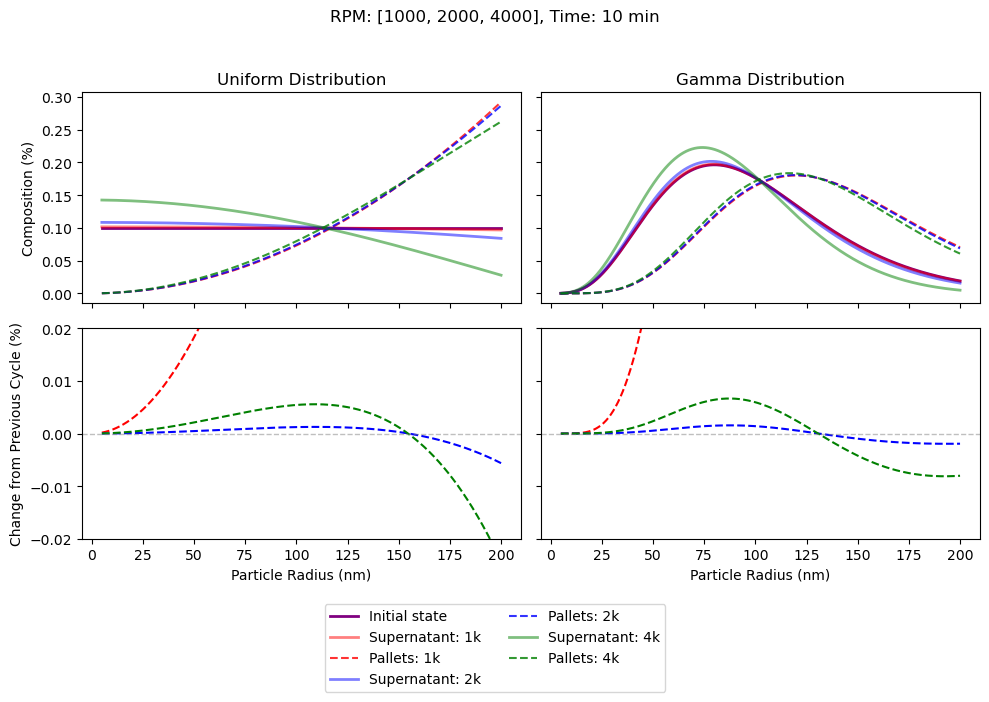

In [132]:
# Parameters for plotting
RPMS = [1000, 2000, 4000]
count = 1000

# Initial size distribution - uniform distribution
size = np.linspace(5, 200, count) * 1e-9

shape_param = 5  # shape parameter (k)
scale_param = 20  # scale parameter (theta)

# Two different distributions
probability_uniformed = np.ones(count)
probability_gamma = gamma.pdf(size * 1e9, shape_param, scale=scale_param)

# Normalize the probability
probability_uniformed /= np.sum(probability_uniformed)
probability_gamma /= np.sum(probability_gamma)

times = 10

# Color cycle for different runs
colors = ['red', 'blue', 'green']
index = 0

fig, ax = plt.subplots(2, 2, figsize=(10, 6), sharex='col', sharey='row')

# Plotting the initial state of the particle distributions
ax[0, 0].plot(size * 1e9, probability_uniformed * 1e2, label="Initial state", linewidth=2, color='purple')
ax[0, 1].plot(size * 1e9, probability_gamma * 1e2, label="Initial state", linewidth=2, color='purple')

pallets_uniformed = np.zeros(count)
pallets_gamma = np.zeros(count)

# Loop over each run
for rpm in RPMS:
    # Holding the initial values to plot the difference
    uni_super_hold = probability_uniformed.copy()
    uni_pallet_hold = pallets_uniformed.copy()

    gam_super_hold = probability_gamma.copy()
    gam_pallet_hold = pallets_gamma.copy()

    # Reset pallets
    pallets_uniformed = np.zeros(count)
    pallets_gamma = np.zeros(count)

    # Loop over each particle size
    for particle in range(count):
        probability_uniformed[particle], pallets_uniformed[particle] = cal_supernate_and_pallets(
            size[particle], probability_uniformed[particle], times,
            particle_density, liquid_density, liquid_viscosity,
            rpm, arm_length, length)

        probability_gamma[particle], pallets_gamma[particle] = cal_supernate_and_pallets(
            size[particle], probability_gamma[particle], times,
            particle_density, liquid_density, liquid_viscosity,
            rpm, arm_length, length)

    # Normalize probabilities and pallets
    probability_uniformed /= np.sum(probability_uniformed)
    pallets_uniformed /= np.sum(pallets_uniformed)

    probability_gamma /= np.sum(probability_gamma)
    pallets_gamma /= np.sum(pallets_gamma)

    # Plot the results for the current RPM
    ax[0, 0].plot(size * 1e9, probability_uniformed * 1e2, label=f"Supernatant: {rpm/1000:.0f}k", alpha=0.5, linewidth=2, color=colors[index])
    ax[0, 0].plot(size * 1e9, pallets_uniformed * 1e2, label=f"Pallets: {rpm/1000:.0f}k", alpha=0.8, linestyle='--', color=colors[index])

    ax[0, 1].plot(size * 1e9, probability_gamma * 1e2, label=f"Supernatant: {rpm/1000:.0f}k", alpha=0.5, linewidth=2, color=colors[index])
    ax[0, 1].plot(size * 1e9, pallets_gamma * 1e2, label=f"Pallets: {rpm/1000:.0f}k", alpha=0.8, linestyle='--', color=colors[index])

    # Plotting the change vs previous cycle

    # ax[1, 0].plot(size * 1e9, np.diff([uni_super_hold, probability_uniformed], axis=0).T * 1e2, color=colors[index])
    ax[1, 0].plot(size * 1e9, np.diff([uni_pallet_hold, pallets_uniformed], axis=0).T * 1e2, color=colors[index], linestyle='--')

    # ax[1, 1].plot(size * 1e9, np.diff([gam_super_hold, probability_gamma], axis=0).T * 1e2, color=colors[index])
    ax[1, 1].plot(size * 1e9, np.diff([gam_pallet_hold, pallets_gamma], axis=0).T * 1e2, color=colors[index], linestyle='--')

    index += 1

ax[1,0].axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax[1,1].axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)

# Titles and labels
ax[0, 0].set_title("Uniform Distribution")
ax[0, 1].set_title("Gamma Distribution")
fig.suptitle(f"RPM: {RPMS}, Time: {times} min")

# X-axis labels
ax[1, 0].set_xlabel("Particle Radius (nm)")
ax[1, 1].set_xlabel("Particle Radius (nm)")

# Y-axis labels
ax[0, 0].set_ylabel("Composition (%)")
ax[1, 0].set_ylabel("Change from Previous Cycle (%)")

ax[1,0].set_ylim([-0.02,0.02])

# Shared legend below the plots
handles, labels = ax[0, 1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.0), ncol=2)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

---

### Importing and Validating the Data - Before Model Comparison

The data from the 2023 centrifugation experiments has been recorded and will be used to compare with the results from the model detailed above.

One of the challenges with this dataset (and centrifugation data for that fact,) is that each cycle's samples are collected from the supernatant of the previous run. This means that the data represents the composition (%) of the portion collected after each centrifugation cycle. Understanding this context is crucial for interpreting the results accurately.

As part of the data import process, it's essential to validate that the data is consistent with our expectations. A key characteristic to check is whether the composition percentages for each cycle sum to one (100%). If they do not, it could indicate an error in the data. For example, the data labeled "run 1 - 2kp" (which represents the size compositions of the pellets collected after the 2k RPM cycle) should sum to one. If it doesn't, this could suggest that particles outside the specified radii range (5-150 nm) are present but not captured in the dataset, or that the data is incomplete.

It's also worth noting that the data might have been artificially normalized beforehand, which is something we need to account for. However, this should not pose any issues because even if the data series do not initially sum to one, they can be normalized. Our focus is on the change in composition over the radii range (5-150 nm), so the exact sum is less critical than the relative differences.

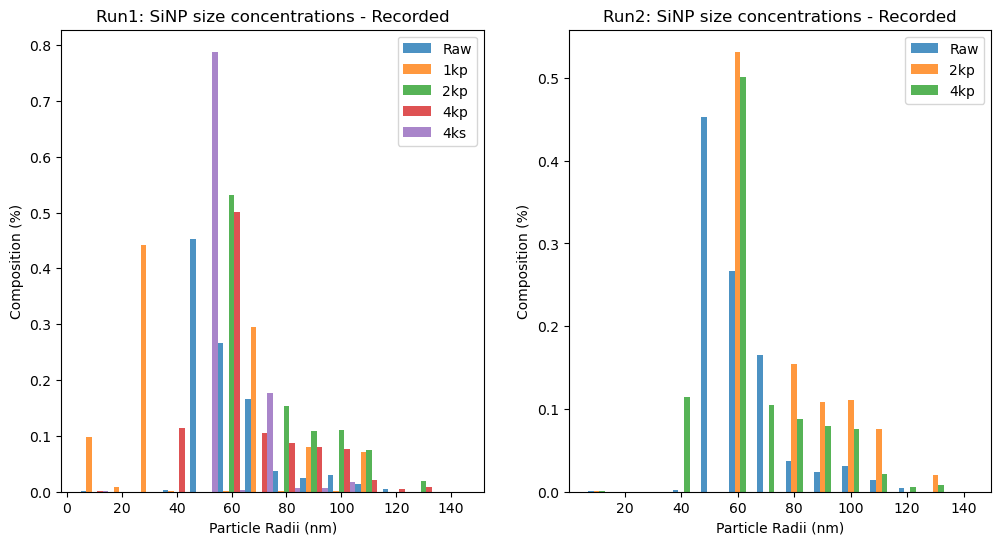

In [16]:
# how does the experimental data look?
# data = load_data_from_txt('/Users/william/Developer/Nano-Particle-Playground/data/Centrifugation/Week 5 - Data/concentrations - week 5.txt')
data = load_data_from_excel('data/Centrifugation/centrifugation_2023.xlsx', load_all_sheets=True)
run1 = data['run1']
run2 = data['run2']

# Plotting the data to see what the change in composition looks like over time
fig = plot_centrifuge_data(run1, run2, mask_limit=0, bar_width = 2)

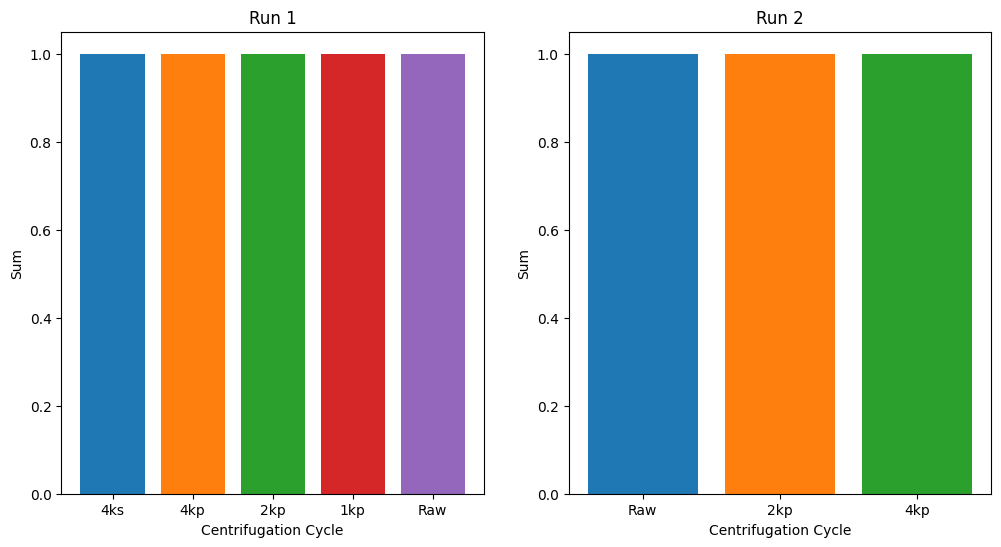

In [7]:
# Checking to see if all the values add up to one.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot for run 1
ax1.set_title("Run 1")
ax1.set_xlabel('Centrifugation Cycle')
ax1.set_ylabel("Sum")
for ii in run1.columns:
    if ii != 'Radii(nm)':
        ax1.bar(ii, sum(run1[ii]))

# plot for run 2
ax2.set_title("Run 2")
ax2.set_xlabel('Centrifugation Cycle')  
ax2.set_ylabel("Sum")

for ii in run2.columns:  
    if ii != 'Radii(nm)':
        ax2.bar(ii, sum(run2[ii]))

In the above plots, we can see that for both Run 1 and Run 2, each centrifugation cycle sums to one. This matches our expectations for the data, confirming that the data is consistent and that each cycle's composition percentages are properly normalized. Since the data already sums to one, there is no need to perform additional normalization, allowing us to proceed directly with the model comparison and analysis.

### Questions about the data...
*What are the units for the recorded concentration?*
- The concentrations or percent compositions are normalised, the concentration units are particles per molar. but goven these are composition (%) each run can not be compared directly to each run.

*What is the duration of the centrifugation events?*
- I am going to assume that centrifugation was on a 10 min duration

*Is each recording from the samme Raw sample?*
- No, each sample is taken from the supernate of the previous cycle.

*Is 2kp initally taken from Raw or 1kp?*
- Assuming that Raw is the inital state for each of the centrifugation runs --> meaning that each recording is operated in a single centrifugation cycle

#### Centrifugation sample paths
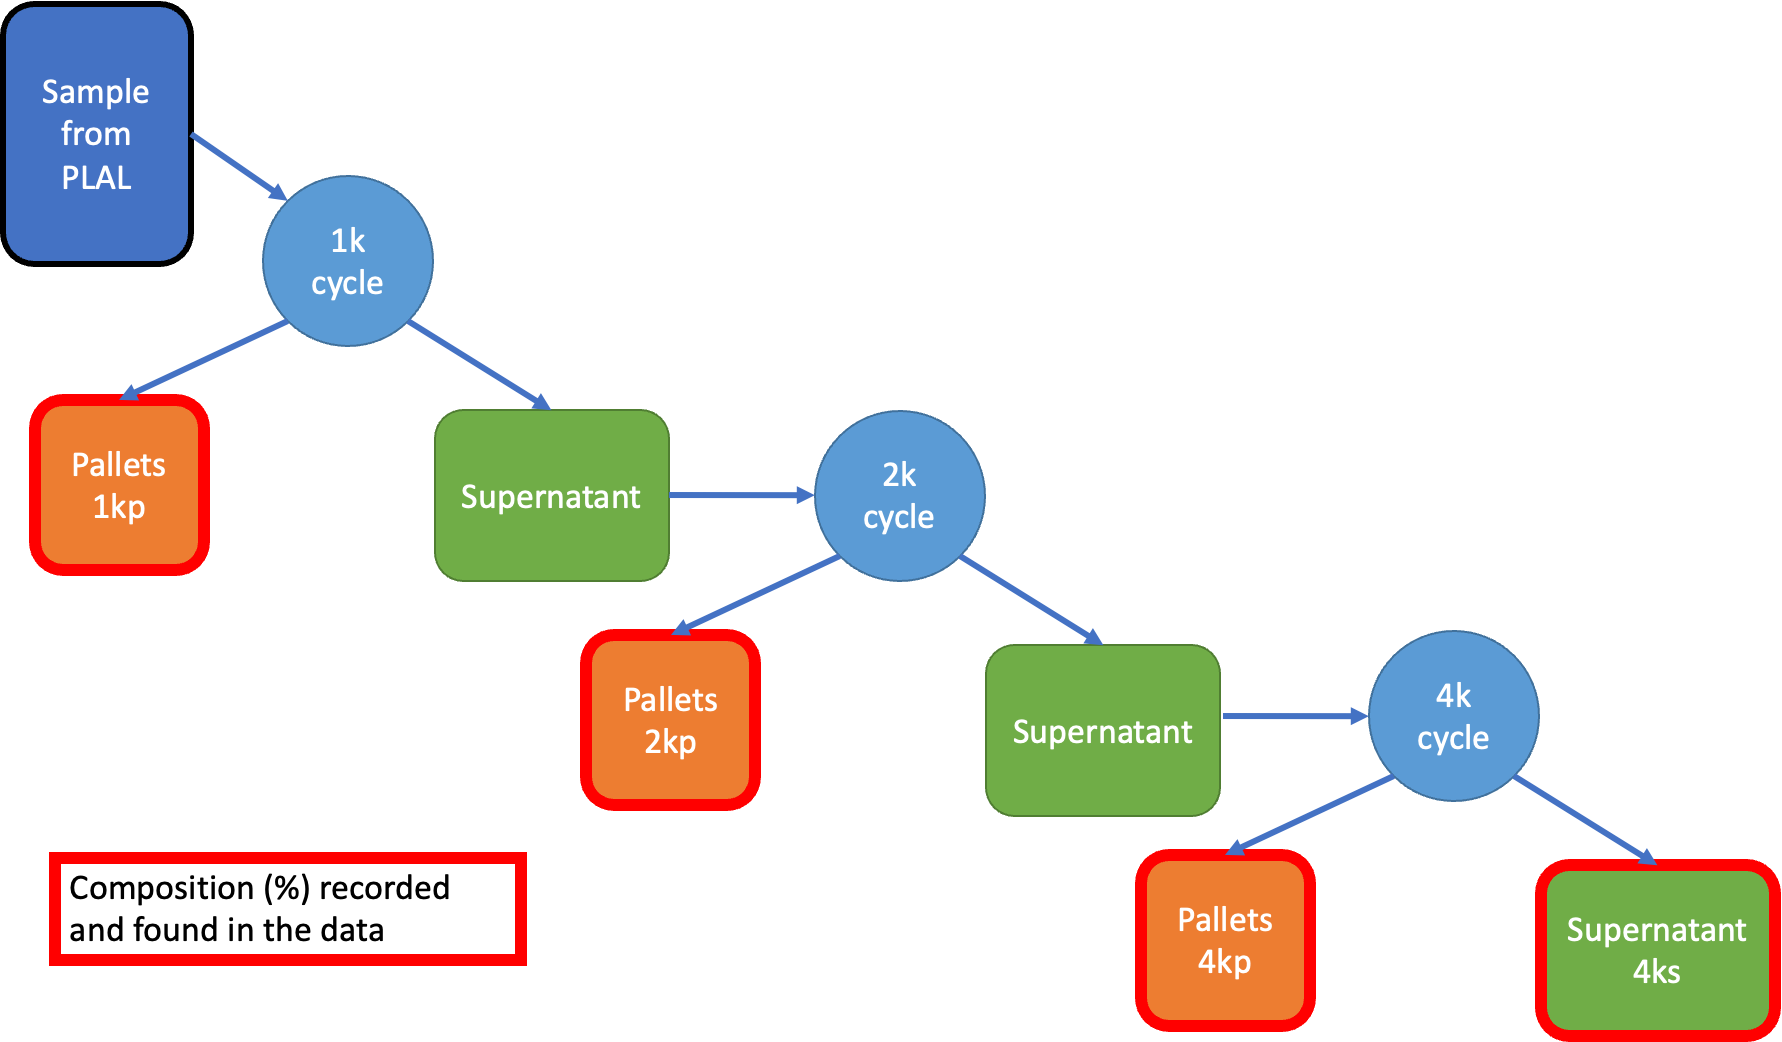

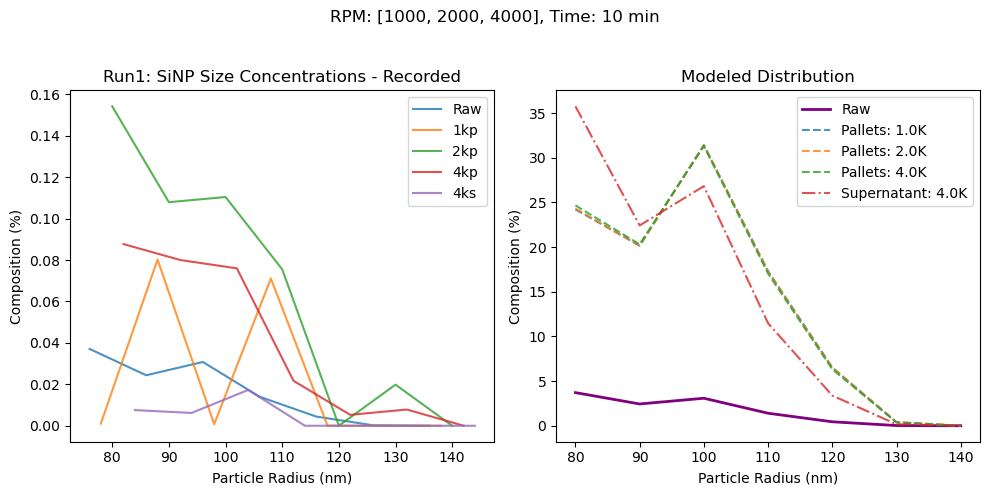

In [35]:
# How does the recorded size distribution change over time compared to the model?
# Parameters
RPMS = [1000, 2000, 4000]

# Plot for run1 (Side-by-side Bars)
mask1 = run1['Radii(nm)'] > 70
radii1 = run1['Radii(nm)'][mask1]

# Initial size distribution - uniform distribution
size = run1['Radii(nm)'][mask1].copy().to_numpy() * 1e-9
count = len(size)

# Experimental initial distribution
probability_experimental = run1['Raw'][mask1].copy().to_numpy()

# Centrifugation time (could be named duration)
times = 10

# Set up the figure and subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))


offset = 2
bar_width = offset
ax1 = ax[0]

ax1.plot(radii1 - 2 * offset, run1['Raw'][mask1], linestyle='-', label='Raw', alpha=0.8)
ax1.plot(radii1 - 1 * offset, run1['1kp'][mask1], linestyle='-', label='1kp', alpha=0.8)
ax1.plot(radii1, run1['2kp'][mask1], linestyle='-', label='2kp', alpha=0.8)
ax1.plot(radii1 + offset, run1['4kp'][mask1], linestyle='-', label='4kp', alpha=0.8)
ax1.plot(radii1 + 2 * offset, run1['4ks'][mask1], linestyle='-', label='4ks', alpha=0.8)

# Titles and labels for the first subplot
ax1.set_title("Run1: SiNP Size Concentrations - Recorded")
ax1.set_ylabel("Composition (%)")
ax1.set_xlabel("Particle Radii (nm)")
ax1.legend()

# Plot the initial state of the particle distributions
ax[1].plot(size * 1e9, probability_experimental * 1e2, label="Raw", linewidth=2, color='purple')

run1_model = {}

run1_model['Radii(nm)'] = size * 1e9

# Loop over each RPM value
for RPM in RPMS:
    # Reset pallets to zero for each run
    pallets_uniformed = np.zeros(count)

    # Loop over each particle size
    for particle in range(count):
        probability_experimental[particle], pallets_uniformed[particle] = cal_supernate_and_pallets(
            size[particle], probability_experimental[particle], times,
            particle_density, liquid_density, liquid_viscosity,
            RPM, arm_length, length
        )
        
    # Normalize probabilities and pallets
    probability_experimental /= np.sum(probability_experimental)
    pallets_uniformed /= np.sum(pallets_uniformed)

    # Plot the pallets and supernatant
    ax[1].plot(size * 1e9, pallets_uniformed * 1e2, label=f"Pallets: {RPM / 1000}K", alpha=0.8, linestyle='--')

    # Saving the data to a dict
    run1_model[f"{RPM / 1000:.0f}ks"] = probability_experimental
    run1_model[f"{RPM / 1000:.0f}kp"] = pallets_uniformed

# Convert the saved dict to a df
run1_model_df = pd.DataFrame.from_dict(run1_model)

ax[1].plot(size * 1e9, probability_experimental * 1e2, label=f"Supernatant: {RPM / 1000}K", alpha=0.8, linestyle='-.')

# Titles and labels for the second subplot
ax[1].set_title("Modeled Distribution")
ax[1].legend()

fig.suptitle(f"RPM: {RPMS}, Time: {times} min")

# Assigning labels to plot axes
for a in ax:
    a.set_xlabel("Particle Radius (nm)")
ax[1].set_ylabel("Composition (%)")

# Final adjustments and plot display
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

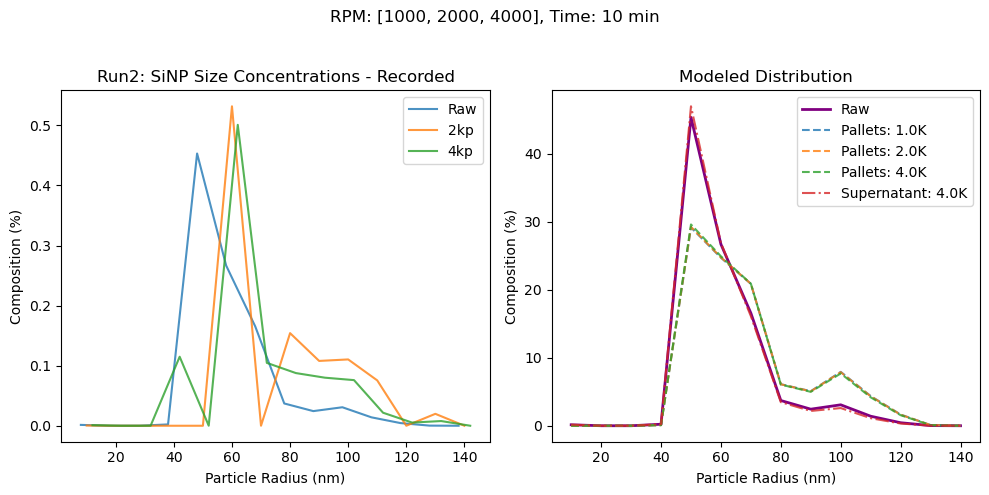

In [18]:
# How does the recorded size distribution change over time compared to the model?
# Parameters
RPMS = [1000, 2000, 4000]

# Initial size distribution - uniform distribution
size = run2['Radii(nm)'].copy().to_numpy() * 1e-9
count = len(size)

# Experimental initial distribution
probability_experimental = run2['Raw'].copy().to_numpy()

# Centrifugation time (could be named duration)
times = 10

# Set up the figure and subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot for run1 (Side-by-side Bars)
mask2 = run2['Radii(nm)'] > 0
radii2 = run2['Radii(nm)'][mask2]

offset = 2
bar_width = offset
ax2 = ax[0]

ax2.plot(radii2 - offset, run2['Raw'][mask2], label='Raw', alpha=0.8)
ax2.plot(radii2, run2['2kp'][mask2], label='2kp', alpha=0.8)
ax2.plot(radii2 + offset, run2['4kp'][mask2], label='4kp', alpha=0.8)

# Titles and labels for the first subplot
ax2.set_title("Run2: SiNP Size Concentrations - Recorded")
ax2.set_ylabel("Composition (%)")
ax2.set_xlabel("Particle Radii (nm)")
ax2.legend()

# Plot the initial state of the particle distributions
ax[1].plot(size * 1e9, probability_experimental * 1e2, label="Raw", linewidth=2, color='purple')

run2_model = {}

run2_model['Radii(nm)'] = size * 1e9

# Loop over each RPM value
for RPM in RPMS:
    # Reset pallets to zero for each run
    pallets_uniformed = np.zeros(count)

    # Loop over each particle size
    for particle in range(count):
        probability_experimental[particle], pallets_uniformed[particle] = cal_supernate_and_pallets(
            size[particle], probability_experimental[particle], times,
            particle_density, liquid_density, liquid_viscosity,
            RPM, arm_length, length
        )
        
    # Normalize probabilities and pallets
    probability_experimental /= np.sum(probability_experimental)
    pallets_uniformed /= np.sum(pallets_uniformed)

    # Plot the pallets and supernatant
    ax[1].plot(size * 1e9, pallets_uniformed * 1e2, label=f"Pallets: {RPM / 1000}K", alpha=0.8, linestyle='--')

    # Saving the data to a dict
    run2_model[f"{RPM / 1000:.0f}ks"] = probability_experimental
    run2_model[f"{RPM / 1000:.0f}kp"] = pallets_uniformed

# Convert the saved dict to a df
run2_model_df = pd.DataFrame.from_dict(run2_model)

ax[1].plot(size * 1e9, probability_experimental * 1e2, label=f"Supernatant: {RPM / 1000}K", alpha=0.8, linestyle='-.')

# Titles and labels for the second subplot
ax[1].set_title("Modeled Distribution")
ax[1].legend()

fig.suptitle(f"RPM: {RPMS}, Time: {times} min")

# Assigning labels to plot axes
for a in ax:
    a.set_xlabel("Particle Radius (nm)")
ax[1].set_ylabel("Composition (%)")

# Final adjustments and plot display
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

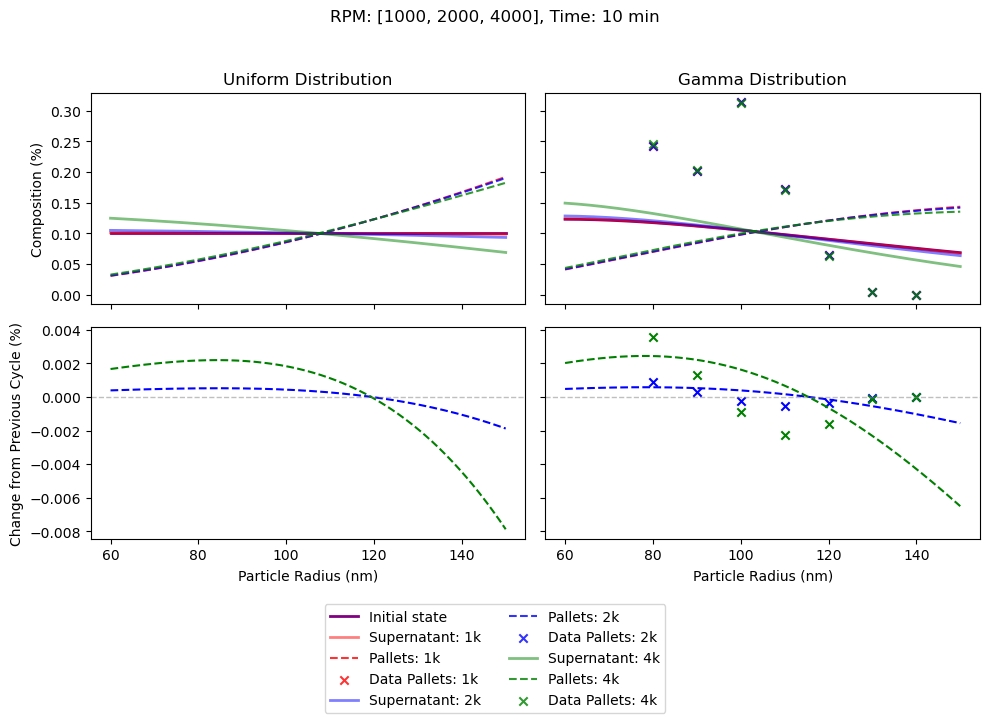

In [117]:
# Parameters for plotting
RPMS = [1000, 2000, 4000]
count = 1000

# Initial size distribution - uniform distribution
size = np.linspace(60, 150, count) * 1e-9

shape_param = 2  # shape parameter (k)
scale_param = 60  # scale parameter (theta)

# Two different distributions
probability_uniformed = np.ones(count)
probability_gamma = gamma.pdf(size * 1e9, shape_param, scale=scale_param)

# Normalize the probability
probability_uniformed /= np.sum(probability_uniformed)
probability_gamma /= np.sum(probability_gamma)

times = 10

# Color cycle for different runs
colors = ['red', 'blue', 'green']
index = 0

fig, ax = plt.subplots(2, 2, figsize=(10, 6), sharex='col', sharey='row')

# Plotting the initial state of the particle distributions
ax[0, 0].plot(size * 1e9, probability_uniformed * 1e2, label="Initial state", linewidth=2, color='purple')
ax[0, 1].plot(size * 1e9, probability_gamma * 1e2, label="Initial state", linewidth=2, color='purple')

pallets_uniformed = np.zeros(count)
pallets_gamma = np.zeros(count)

# Loop over each run
for rpm in RPMS:
    # Holding the initial values to plot the difference
    uni_super_hold = probability_uniformed.copy()
    uni_pallet_hold = pallets_uniformed.copy()

    gam_super_hold = probability_gamma.copy()
    gam_pallet_hold = pallets_gamma.copy()

    # Reset pallets
    pallets_uniformed = np.zeros(count)
    pallets_gamma = np.zeros(count)

    # Loop over each particle size
    for particle in range(count):
        probability_uniformed[particle], pallets_uniformed[particle] = cal_supernate_and_pallets(
            size[particle], probability_uniformed[particle], times,
            particle_density, liquid_density, liquid_viscosity,
            rpm, arm_length, length)

        probability_gamma[particle], pallets_gamma[particle] = cal_supernate_and_pallets(
            size[particle], probability_gamma[particle], times,
            particle_density, liquid_density, liquid_viscosity,
            rpm, arm_length, length)

    # Normalize probabilities and pallets
    probability_uniformed /= np.sum(probability_uniformed)
    pallets_uniformed /= np.sum(pallets_uniformed)

    probability_gamma /= np.sum(probability_gamma)
    pallets_gamma /= np.sum(pallets_gamma)

    # Plot the results for the current RPM
    ax[0, 0].plot(size * 1e9, probability_uniformed * 1e2, label=f"Supernatant: {rpm/1000:.0f}k", alpha=0.5, linewidth=2, color=colors[index])
    ax[0, 0].plot(size * 1e9, pallets_uniformed * 1e2, label=f"Pallets: {rpm/1000:.0f}k", alpha=0.8, linestyle='--', color=colors[index])

    ax[0, 1].plot(size * 1e9, probability_gamma * 1e2, label=f"Supernatant: {rpm/1000:.0f}k", alpha=0.5, linewidth=2, color=colors[index])
    ax[0, 1].plot(size * 1e9, pallets_gamma * 1e2, label=f"Pallets: {rpm/1000:.0f}k", alpha=0.8, linestyle='--', color=colors[index])
    ax[0, 1].scatter(run1_model_df['Radii(nm)'], run1_model_df[f'{rpm/1000:.0f}kp'], label=f"Data Pallets: {rpm/1000:.0f}k", marker='x', alpha=0.8, color=colors[index])

    # Plotting the change vs previous cycle
    if rpm != 1000 and rpm != 3000:
        # ax[1, 0].plot(size * 1e9, np.diff([uni_super_hold, probability_uniformed], axis=0).T * 1e2, color=colors[index])
        ax[1, 0].plot(size * 1e9, np.diff([uni_pallet_hold, pallets_uniformed], axis=0).T * 1e2, color=colors[index], linestyle='--')

        # ax[1, 1].plot(size * 1e9, np.diff([gam_super_hold, probability_gamma], axis=0).T * 1e2, color=colors[index])
        ax[1, 1].plot(size * 1e9, np.diff([gam_pallet_hold, pallets_gamma], axis=0).T * 1e2, color=colors[index], linestyle='--')
        ax[1, 1].scatter(run1_model_df['Radii(nm)'], np.diff([run1_model_df[f'{(rpm/1000)-1:.0f}kp'], run1_model_df[f'{(rpm/1000):.0f}kp']], axis=0), marker='x', color=colors[index])

    index += 1

ax[1,0].axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax[1,1].axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)

# Titles and labels
ax[0, 0].set_title("Uniform Distribution")
ax[0, 1].set_title("Gamma Distribution")
fig.suptitle(f"RPM: {RPMS}, Time: {times} min")

# X-axis labels
ax[1, 0].set_xlabel("Particle Radius (nm)")
ax[1, 1].set_xlabel("Particle Radius (nm)")

# Y-axis labels
ax[0, 0].set_ylabel("Composition (%)")
ax[1, 0].set_ylabel("Change from Previous Cycle (%)")

# Shared legend below the plots
handles, labels = ax[0, 1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.0), ncol=2)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [59]:
np.diff([uni_super_hold, probability_uniformed], axis=0).shape

(1, 1000)

From these two runs, it’s unclear whether the models are reflecting the same level of change in particle distribution as the experimental results. The experimental data is inherently messy due to the nature of the experiment. Further analysis on the change in average size composition will be conducted to determine if there is a significant change in the experimental data.

In [137]:
# Calculating the average of each cycle
run1_model_avg = cal_average_size(run1_model_df)
run1_avg = cal_average_size(run1)

run2_model_avg = cal_average_size(run2_model_df)
run2_avg = cal_average_size(run2)
run1.columns.to_list()


['Radii(nm)', '4ks', '4kp', '2kp', '1kp', 'Raw']

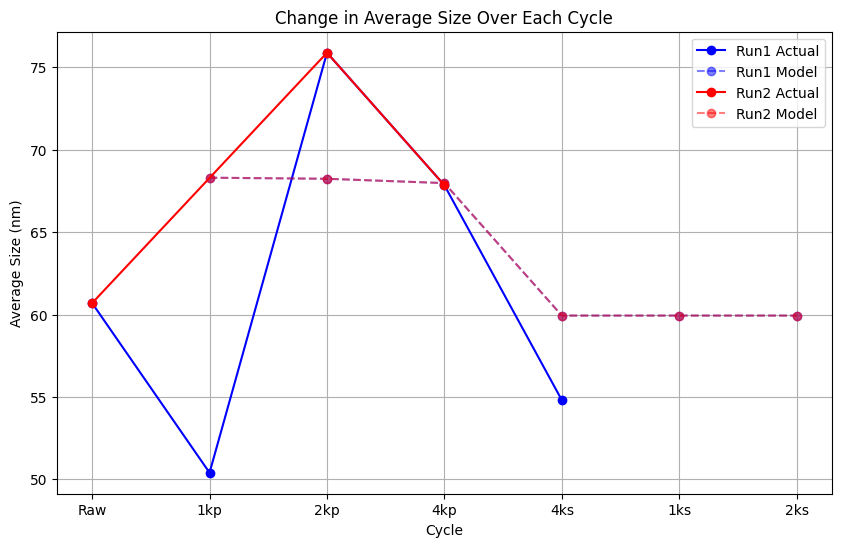

In [138]:
# Define the correct order for the cycles
cycle_order = ['Raw', '1kp', '2kp', '4kp', '4ks', '1ks', '2ks']

# Convert the 'Cycle' columns to categorical types with the specified order
run1_avg['Cycle'] = pd.Categorical(run1_avg['Cycle'], categories=cycle_order, ordered=True)
run1_model_avg['Cycle'] = pd.Categorical(run1_model_avg['Cycle'], categories=cycle_order, ordered=True)
run2_avg['Cycle'] = pd.Categorical(run2_avg['Cycle'], categories=cycle_order, ordered=True)
run2_model_avg['Cycle'] = pd.Categorical(run2_model_avg['Cycle'], categories=cycle_order, ordered=True)

# Sort the dataframes by the 'Cycle' column
run1_avg = run1_avg.sort_values('Cycle')
run1_model_avg = run1_model_avg.sort_values('Cycle')
run2_avg = run2_avg.sort_values('Cycle')
run2_model_avg = run2_model_avg.sort_values('Cycle')
# Plotting the average size change for each run and model
plt.figure(figsize=(10, 6))

# Run 1
plt.plot(run1_avg['Cycle'], run1_avg['Average Size (nm)'], marker='o', linestyle='-', label='Run1 Actual', color='blue')
plt.plot(run1_model_avg['Cycle'], run1_model_avg['Average Size (nm)'], marker='o', linestyle='--', label='Run1 Model', color='blue', alpha=0.5)

# Run 2
plt.plot(run2_avg['Cycle'], run2_avg['Average Size (nm)'], marker='o', linestyle='-', label='Run2 Actual', color='red')
plt.plot(run2_model_avg['Cycle'], run2_model_avg['Average Size (nm)'], marker='o', linestyle='--', label='Run2 Model', color='red', alpha=0.5)

# Adding labels and title
plt.xlabel("Cycle")
plt.ylabel("Average Size (nm)")
plt.title("Change in Average Size Over Each Cycle")
plt.legend()
plt.grid(True)
plt.show()

The change in position between the two runs is negligible. This outcome is expected since the initial raw data points are identical, and the centrifugation speeds are relatively low. As a result, skipping the 1k cycle has minimal impact on the overall change in the size distribution